In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SquaredExponentialKernel:
    def __init__(self,L=np.eye(10),sigma_f=1):
        self.L = L
        self.sigma_f = sigma_f
        
    def __call__(self, argument_1,argument_2):

        #print(argument_1.shape)
        #print(argument_2.shape)
        difference = argument_1-argument_2
        
        return float(self.sigma_f**2 * np.exp(-1/2*difference.T.dot(np.linalg.inv(self.L*self.L)).dot(difference)))

In [3]:
def calculate_covariance_matrix(x1,x2,covariance_function):
    # need to rework this. It needs to iterate over samples, not features
    #return np.array([[ for a in x1] for b in x2])

    cov_mat = np.empty((x1.shape[0], x2.shape[0]))*np.NaN
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    #print(cov_mat.shape)
    #print('New cov matrix calc')
    #print(x1.shape)
    #print(x2.shape)
    for i in range(x1.shape[0]):
        a = x1[i,:].reshape(-1,1)
        for j in range(x2.shape[0]):
            
            b = x2[j,:].reshape(-1,1)
            #print(a.shape)
            #print(b.shape)
            cov_mat[i,j] = covariance_function(a,b)
            
    return cov_mat
    

In [4]:
class GPR:
    def __init__(self,
                 z_train,
                 y_train,
                 covariance_function,
                 noise=0.0):
        self.z_train = z_train
        self.y_train = y_train
        self.covariance_function = covariance_function
        self.noise = noise
        self._memory = None
        
        self.inv_cov_matrix_of_input_data = np.linalg.inv(
            calculate_covariance_matrix(z_train, z_train, covariance_function) \
            + (noise+1e-7)*np.identity(len(z_train)))

    def predict(self,at_values_y, var=False):
        
        sigma_k = calculate_covariance_matrix(self.z_train, at_values_y, self.covariance_function)
        sigma_kk = calculate_covariance_matrix(at_values_y, at_values_y, self.covariance_function)
        
        #print(sigma_k.shape)
        #print(self.inv_cov_matrix_of_input_data.shape)
        #print(self.y_train.shape)
        mean_at_values = sigma_k.T.dot(
                                self.inv_cov_matrix_of_input_data.dot(
                                    self.y_train))
        
        covar_matrix = sigma_kk - sigma_k.T.dot(
                                self.inv_cov_matrix_of_input_data.dot(
                                    sigma_k))


        variance = np.diag(covar_matrix)
        self._memory = {'mean': mean_at_values, 'covariance_matrix': covar_matrix, 'variance':variance}
        
        if var:
            return mean_at_values, covar_matrix
        else:  
            return mean_at_values

In [5]:
from save_dataset import load_dict

data = load_dict('data/trajectory.pkl')


data_reduction_n = 1
#print(data)
v = data['v'][1::data_reduction_n]
v_pred = data['v_pred'][1::data_reduction_n]
a_validation = data['aero_drag'][1::data_reduction_n]

a_error = (v - v_pred)/data['dt']

z_train = np.concatenate((data['p'][1::data_reduction_n,:], data['q'][1::data_reduction_n,:], data['v'][1::data_reduction_n,:], data['w'][1::data_reduction_n,:], data['u'][1::data_reduction_n,:]),axis=1)
y_train = a_error[:,0] # just x dimension



n_samples = 10
n_sub = int(y_train.shape[0]/n_samples)
z_subsampled = z_train[::n_sub]
y_subsampled = y_train[::n_sub]
y_subsampled = y_subsampled.reshape((-1,1))

print(z_train.shape)

(10000, 17)


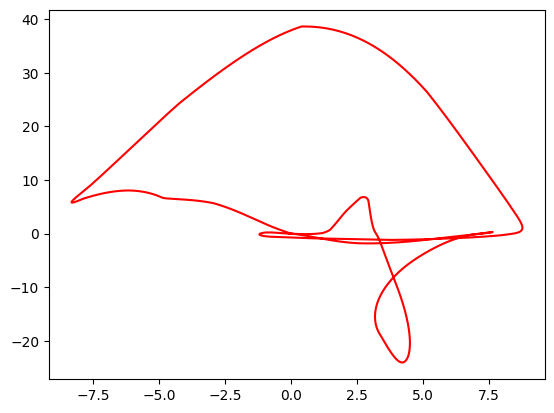

In [6]:
plt.figure()
#plt.plot(v[:100,0]**2*np.sign(v[:100,0]),a_error[:100,0], 'bo')
#plt.plot(v[:,0],a_error[:,0])
plt.plot(v[:,0], a_validation[:,0], 'r')
#plt.plot(v_pred[:100,0],a_error[:100,0])


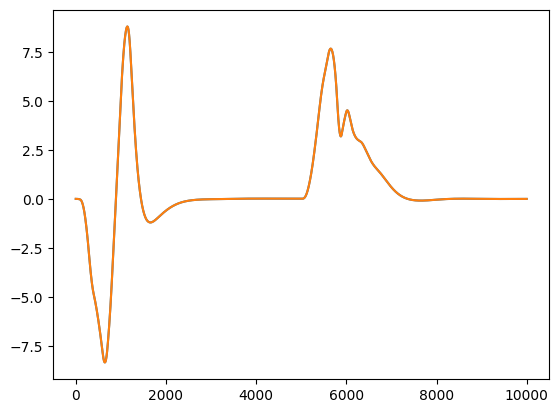

In [7]:
plt.figure()
#plt.plot(v[:100,0]**2*np.sign(v[:100,0]),a_error[:100,0], 'bo')
#plt.plot(v[:,0],a_error[:,0])
plt.plot(v[:,0])
plt.plot(v_pred[:,0])

#plt.plot(v_pred[:100,0],a_error[:100,0])


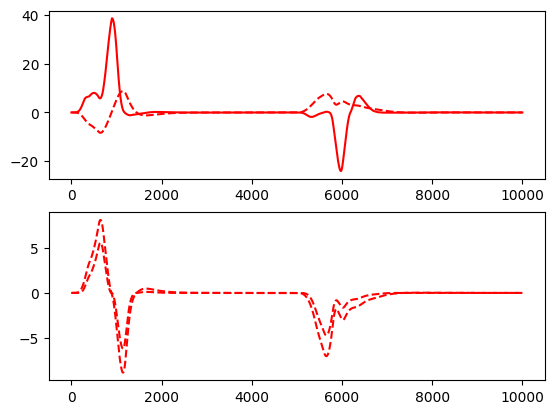

In [13]:
plt.figure()
plt.subplot(211)
plt.plot(a_validation[:,0], 'r')
plt.plot(v[:,0], 'r--')

#plt.plot(0.08*-v_pred[:,0]**2*np.sign(v_pred[:,0]), 'r--')
#plt.plot(y_train, 'r--')
plt.subplot(212)
#plt.plot(a_validation[:,0], 'r')
plt.plot(0.08*-v[:,0]**2*np.sign(v[:,0]), 'r--')
plt.plot(y_train, 'r--')

In [9]:
kernel = SquaredExponentialKernel(L=np.eye(z_subsampled.shape[1]))

model = GPR(z_subsampled, y_subsampled, noise=0.1, covariance_function=kernel)
mean, var = model.predict(z_train, var=True)

rms = np.sqrt(np.mean((y_train - mean)**2))
print(rms)

/tmp/ipykernel_26069/256817880.py:5: RuntimeWarning: invalid value encountered in multiply
  cov_mat = np.empty((x1.shape[0], x2.shape[0]))*np.NaN


KeyboardInterrupt: 

In [ ]:
sampling_ns = [3, 5, 10, 20, 50, 100]

rms = np.empty((len(sampling_ns),))*np.NaN

for i in range(len(sampling_ns)):
    n_samples = sampling_ns[i]
    n_sub = int(z_train.shape[0]/n_samples)
    z_subsampled = z_train[::n_sub]
    y_subsampled = y_train[::n_sub]
    y_subsampled = y_subsampled.reshape((-1,1))
    
    print(y_subsampled.shape)
    kernel = SquaredExponentialKernel(L=np.eye(z_subsampled.shape[1]))

    model = GPR(z_subsampled, y_subsampled, noise=0.0, covariance_function=kernel)
    mean, var = model.predict(z_train, var=True)

    rms[i] = np.sqrt(np.mean((y_train - mean)**2))

rms

In [ ]:


plt.figure()
plt.plot(sampling_ns, rms)